# Kernel Description

This notebook demonstrates the data analysis on the behaviour of loan borrowers. As to why do they apply for a loan. How many of them are actually able to pay for it and how many become defaulters. Can we determine a pattern for a good or a bad loan? To make our visualizations more interactive we will be using all our charts with plotly, an interactive library that will allow us to have a better insight about our data. 

**Note: This project will be subjected to constant updates in the near future. Also, I am open to listen insights from Kagglers about this project.**

# Table of Contents

<ul style="font-size: 18px">
    <li><a>Load Data and Libraries</a></li>
    <li><a>Data Pre-Processing</a></li>
    <li><a>Feature Engineering</a></li>
    <li><a>Exploratory Data Analysis (Uni-Variate)</a></li>
    <li><a>Exploratory Data Analysis (Multi-Variate)</a></li>
    <li><a>Conclusion</a></li>
</ul>

# Load Data and Libraries 

In [1]:
from fastai.imports import *
from time import strptime

import pandas_profiling # library for automatic EDA

import plotly.express as px
from plotly.offline import iplot
import plotly.graph_objects as go

from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 120) # Setting pandas to display a N number of columns
pd.set_option('display.max_rows', 10) # Setting pandas to display a N number rows
pd.set_option('display.width', 1000) # Setting pandas dataframe display width to N

In [2]:
df_raw = pd.read_csv('input/loan.csv', low_memory=False)
df_state_codes = pd.read_csv('input/us-state-codes.csv')

print(f'Rows : {df_raw.shape[0]}\tCols : {df_raw.shape[1]}')

df_state_codes['state_code'] = df_state_codes['state_code'].apply(lambda x: x[-2:])

Rows : 39717	Cols : 111


# Data Pre-Processing

In [7]:
na_values = pd.DataFrame(df_raw.isnull().sum()/len(df_raw))
na_values.rename(columns={0: 'Number_of_nulls'}, inplace=True)
na_values = na_values[na_values['Number_of_nulls'] > 0.3]
fig = px.bar(na_values*100, labels={"index": "Column Names", "value": "% Missing"})
fig.update_layout(title = 'Columns with more than 30% missing values', width=1000, height=500)
fig.show()

In [4]:
cols_to_be_del = (df_raw.isnull().sum()/len(df_raw))
cols_to_be_del = list(cols_to_be_del[cols_to_be_del.values>=0.3].index)
df_raw.drop(cols_to_be_del, axis =1, inplace=True)

In [5]:
# # # The pandas profiling library is really useful on helping us understand the data we're working on.
# report = pandas_profiling.ProfileReport(df_raw)

# # display(report) # uncomment if you want to print the report in notebook
# report.to_file(output_file='report.html') # to save a html version

# Feature Engineering

In [6]:
data = df_raw.merge(df_state_codes, left_on='addr_state', right_on='state_code')


data['issue_year'] = data['issue_d'].apply(lambda x: x[-2:])
data['issue_month'] = data['issue_d'].apply(lambda x: x[:-3])

data['issue_year'] = data['issue_year'].apply(lambda x: '20'+x).astype('int32')

months_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

data['issue_month'] = pd.Categorical(data['issue_month'], categories=months_order, ordered=True)

loan_status_order = ["Current", "Charged Off", "Fully Paid"]
data['loan_status'] = pd.Categorical(data.loan_status, categories=loan_status_order, ordered=True)

data.sort_values(['issue_year', 'issue_month'], inplace=True)
data.reset_index(inplace=True, drop=True)


data.drop(['issue_d', 'state_code'], axis=1, inplace=True)
data['emp_title'] = data['emp_title'].str.lower()
data['title'] = data['title'].str.lower()
data['title'].replace(['debt consolidation', 'debt consolidation loan'], 'debt consolidation', inplace=True)
data['emp_title'].replace(['us army', 'united states army', 'u.s. army'], 'us army', inplace=True)

In [7]:
unique_v = data.nunique()
unique_v = unique_v[unique_v.values == 1]
print(f'Removing colums: {unique_v.index}')
data.drop(list(unique_v.index), axis =1, inplace=True)

Removing colums: Index(['pymnt_plan', 'initial_list_status', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens'], dtype='object')


In [8]:
data.shape

(39717, 46)

In [9]:
data.emp_length.fillna('0 years',inplace=True)

In [10]:
unnecessary_cols = ['id', 'member_id', 'url', 'zip_code']
data.drop(unnecessary_cols, axis =1, inplace=True)

In [11]:
data.int_rate.tail(2)

39715    11.71%
39716    14.65%
Name: int_rate, dtype: object

In [12]:
data.int_rate = data.int_rate.apply(lambda x: x[:-2]).astype('float32')

In [13]:
unnecessary_cols = ['OTHER', 'NONE']
data.drop(data[data['home_ownership'].isin(unnecessary_cols)].index, inplace=True)

In [14]:
data['loan_income_ratio']= data['loan_amnt']/data['annual_inc']

In [15]:
bins = [0, 5000, 10000, 15000, 20000, 25000, 40000]
slot = ['0-5000', '5000-10000', '10000-15000', '15000-20000', '20000-25000','25000 and above']
data['loan_amnt_range'] = pd.cut(data['loan_amnt'], bins, labels=slot)

In [16]:
bins = [0, 25000, 50000, 75000, 100000,1000000]
slot = ['0-25000', '25000-50000', '50000-75000', '75000-100000', '100000 and above']
data['annual_inc_range'] = pd.cut(data['annual_inc'], bins, labels=slot)

In [17]:
bins = [0., 7.5, 10., 12.5, 15., 20.]
slot = ['0-7.5', '7.5-10', '10-12.5', '12.5-15', '15 and above']
data['int_rate_range'] = pd.cut(data['int_rate'], bins, labels=slot)

In [18]:
bins = [-.0001, 7.5, 13., 19.5, 25., 30.]
slot = ['0-7.5', '7.5-13', '13-19.5', '19.5-25', '25 and above']
data['dti_range'] = pd.cut(data['dti'], bins, labels=slot)

In [19]:
q = data["annual_inc"].quantile(0.99); q
data = data[data["annual_inc"] < q]

In [20]:
def mult_analYsis(col:'column name', graph=True) -> 'go.Figure':
    df1 = DataFrame({'count' : data.groupby(col).size()}).reset_index()
    df2 = DataFrame({'count' : data.groupby(col[0]).size()}).reset_index()
    df1 = df1.merge(df2, on=col[0], suffixes=('', '_total'))
    temp_df = df1[df1.loan_status=='Charged Off']
    df2['prob_charged_off'] = temp_df['count'].values/temp_df['count_total'].values
    df1['ratio'] = df1['count']/df1['count'].sum()
    fig = px.bar(df1, x=col[0], y='ratio', color=col[1])
    fig2 = px.line(df2, x=col[0], y='prob_charged_off')
    fig2.update_traces(line=dict(color='#f1c40f', width=5), showlegend=True, name='Prob. of Charged Off')
    fig.add_trace(fig2.data[0])
    fig.update_layout(template='plotly_dark')
    fig.update_layout(
        title=f"Multi Variate Plot of {col[0]} Vs Probability of getting Charged Off Hued wrt Loan Status",
        xaxis_title=f"{col[0]}",
        yaxis_title=f"Ratio and Probability.(Charged Off)"
    )
    fig.show() if graph else None
    return df1, df2

# Exploratory Data Analysis (Uni-Variate)

### For What reason do people buy loans most

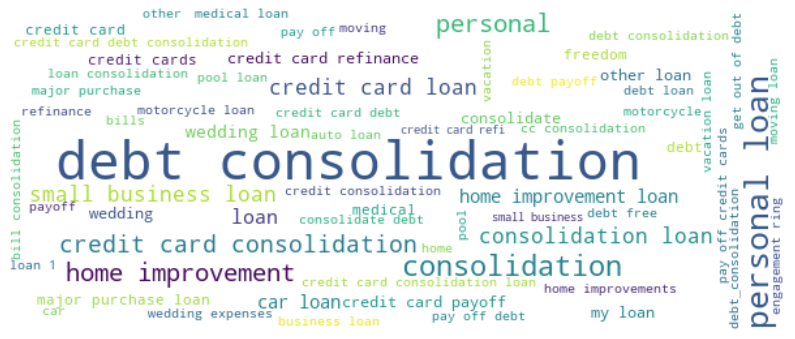

In [21]:
df_emp_cloud=data.title.value_counts()
df_emp_cloud=df_emp_cloud.to_frame().reset_index()
d = dict()
for a, x in df_emp_cloud.values:
    d[a]=x
wordcloud=WordCloud(background_color='white',min_font_size=9, width=600,height=250)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(14,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show();

### Which people tend to buy more loans

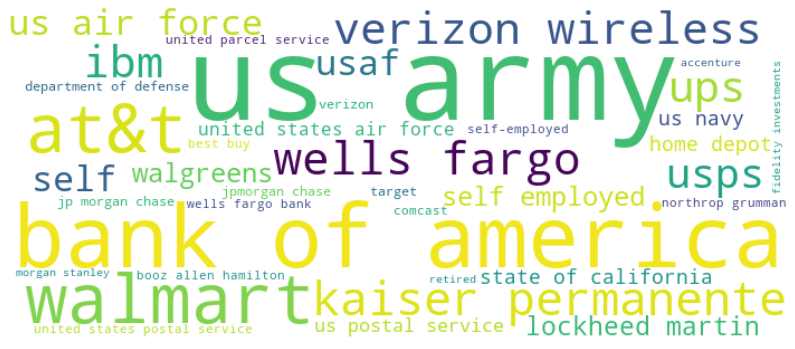

In [22]:
df_emp_cloud=data.emp_title.value_counts()
df_emp_cloud=df_emp_cloud.to_frame().reset_index()
d = dict()
for a, x in df_emp_cloud.values:
    d[a]=x
wordcloud=WordCloud(background_color='white',min_font_size=9, width=700,height=300)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(14,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show();

### Plots

In [23]:
loan_stats_values = pd.DataFrame(data.loan_status.value_counts()); loan_stats_values
fig = px.bar(loan_stats_values, labels={"index": "Loan Status", "value": "Count"})
fig.update_layout(title = 'Loan status for different Categories')
fig.update_traces(marker_line_color='black', marker_line_width=1.5, opacity=0.6)
fig.update_layout(
    title="Frequency Plot for Loan Status over its different types",
    xaxis_title="Loan Status",
    yaxis_title="Frequency"
)
fig.show()

In [24]:
per_year_df = DataFrame({'count' : data.groupby(['issue_year', 'loan_status']).size()}).reset_index()
fig = px.bar(per_year_df, x="issue_year", y="count", color='loan_status')
fig.update_layout(
    title="Frequency Plot for Loan Status over the Years",
    xaxis_title="Loan Issue Year",
    yaxis_title="Frequency"
)
fig.show()

In [25]:
per_month_per_year_df = DataFrame({'count' : data.groupby(['issue_year', 'issue_month']).size()}).reset_index()
fig = px.line(per_month_per_year_df, x="issue_year", y="count", color='issue_month')
fig.update_layout(
    title="Frequency Plot for Loan Status over the years and months",
    xaxis_title="Loan Issue Year",
    yaxis_title="Frequency"
)
fig.show()

In [26]:
purpose_status_df = DataFrame({'count' : data.groupby(['purpose', 'loan_status']).size()}).reset_index()
fig = px.bar(purpose_status_df, x="purpose", y="count", color='loan_status')
fig.update_layout(
    title="Frequency Plot for Loan Status with respect to purpose of loan",
    xaxis_title="Purpose of Loan",
    yaxis_title="Frequency"
)
fig.show()

In [27]:
ownership_status_df = DataFrame({'count' : data.groupby(['home_ownership', 'loan_status']).size()}).reset_index()
fig = px.bar(ownership_status_df, x="home_ownership", y="count", color='loan_status')
fig.update_layout(
    title="Frequency Plot for Loan Status wtith respect to residential status of the applicant",
    xaxis_title="Residential Status",
    yaxis_title="Frequency"
)
fig.show()

In [28]:
by_term_df = DataFrame({'count' : data.groupby(['term', 'loan_status']).size()}).reset_index()
fig = px.bar(by_term_df, x="term", y="count", color='loan_status')
fig.update_layout(
    title="Frequency Plot for Loan Status with respect to term",
    xaxis_title="Term of Loan",
    yaxis_title="Frequency"
)
fig.show()

In [29]:
per_state_df = DataFrame({'count' : data.groupby(['state', 'loan_status']).size()}).reset_index()
fig = px.bar(per_state_df, x="state", y="count", color='loan_status')
fig.update_layout(
    title="Frequency Plot for Loan Status with respect to each state",
    xaxis_title="States",
    yaxis_title="Frequency"
)
fig.show()

In [30]:
by_grade_df = DataFrame({'count' : data.groupby(['grade', 'loan_status']).size()}).reset_index()
fig = px.bar(by_grade_df, x="grade", y="count", color='loan_status')
fig.update_layout(
    title="Frequency Plot for Loan Status with respect to grade",
    xaxis_title="Grade",
    yaxis_title="Frequency"
)
fig.show()

In [31]:
by_subgrade_df = DataFrame({'count' : data.groupby(['sub_grade', 'loan_status']).size()}).reset_index()
fig = px.bar(by_subgrade_df, x="sub_grade", y="count", color='loan_status')
fig.update_layout(
    title="Frequency Plot for Loan Status with respect to subgrade",
    xaxis_title="SubGrade",
    yaxis_title="Frequency"
)
fig.show()

In [32]:
by_dti_status_df = DataFrame({'count' : data.groupby(['dti_range', 'loan_status']).size()}).reset_index(); by_dti_status_df
fig = px.bar(by_dti_status_df, x="dti_range", y="count", color='loan_status')
fig.update_layout(
    title="Frequency Plot for Loan Status with respect Debt to income ratio",
    xaxis_title="Debt to income ratio",
    yaxis_title="Frequency"
)
fig.show()

# Exploratory Data Analysis (Multi-Variate)

In [33]:
df1, df2 = mult_analYsis(col=['addr_state', 'loan_status'], graph=False)
df2['frequency'] = df2['prob_charged_off'].apply(lambda x: x*100)
df2.sort_values(['frequency'], ascending=False, inplace=True)
df2.reset_index(inplace=True , drop=True)
df2.drop(0, axis=0, inplace=True)

fig = px.choropleth(df2, locations='addr_state', color='frequency',
                           color_continuous_scale="Inferno",
                           scope="usa",
                           locationmode = 'USA-states',
                           labels={'frequency':'Deafult Rate'},
                           title="Heat Plot for Default Rate in the States"
                          )

fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0}, template='plotly')
fig.show()

In [34]:
grouped_loan_amnt = data.groupby('annual_inc', as_index=False)['loan_amnt'].mean();
grouped_loan_amnt['MA50'] = grouped_loan_amnt.loan_amnt.rolling(50, min_periods=20).mean()

fig = px.scatter(data, x="annual_inc", y="loan_amnt", color="loan_status", title="Bi-variate")
fig2 = px.line(grouped_loan_amnt, x='annual_inc', y='MA50')
fig2.update_traces(line=dict(color='#f1c40f', width=5), showlegend=True, name='Moving Average')
fig.add_trace(fig2.data[0])
fig.update_layout(
    title="Scatter Plot for Annual Income Vs Loan Amount, Hue wrt Loan Status",
    xaxis_title="Annual Income",
    yaxis_title="Loan Amount"
)
fig.show()

In [35]:
fig = px.box(data, x="purpose", y="loan_amnt", color="loan_status", title="Bi-variate")
fig.update_layout(
    title="Box Plot for Purpose of Loan Vs Loan Amount, Hue wrt Loan Status",
    xaxis_title="Purpose of Loan",
    yaxis_title="Loan Amount"
)
fig.show()

In [36]:
fig = px.box(data, x="emp_length", y="loan_amnt", color="loan_status", title="Bi-variate")
fig.update_layout(
    title="Box Plot for Employment Length Vs Loan Amount, Hue wrt Loan Status",
    xaxis_title="Employment Length",
    yaxis_title="Loan Amount"
)
fig.show()

In [37]:
mult_analYsis(col=['issue_year', 'loan_status']);

In [38]:
mult_analYsis(col=['grade', 'loan_status']);

In [39]:
mult_analYsis(col=['sub_grade', 'loan_status']);

In [40]:
mult_analYsis(col=['state', 'loan_status']);

In [41]:
mult_analYsis(col=['purpose', 'loan_status']);

In [42]:
mult_analYsis(col=['annual_inc_range', 'loan_status']);

In [43]:
mult_analYsis(col=['int_rate_range', 'loan_status']);

In [44]:
mult_analYsis(col=['emp_length', 'loan_status']);

In [45]:
mult_analYsis(col=['home_ownership', 'loan_status']);

In [46]:
mult_analYsis(col=['term', 'loan_status']);

In [47]:
mult_analYsis(col=['dti_range', 'loan_status']);

# Conclusions

# EOF